In [1]:
# %pip install matplotlib-label-lines

import CoolProp.CoolProp as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
import os
import seaborn
from labellines import labelLine, labelLines
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib

plt.rcParams["pdf.fonttype"]=42
plt.rcParams["font.size"] =12


In [2]:
mi18=pd.read_excel(os.getcwd()+'/'+"Literature data (Wieser et al., 2021; DeVitre and Wieser, 2023)\MI_kil18.xlsx")
mi18['MagmaSat_err']=mi18['Magmasat Saturation Pressure Max CO2 (glass+bubble, PEC corr,+1 sigma splitting +1 sigmabubble vol)']-mi18['Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)']

fi18=pd.read_excel(os.getcwd()+'/'+"Literature data (Wieser et al., 2021; DeVitre and Wieser, 2023)\FI_kil18.xlsx")     
                                                                        
fi23=pd.read_excel(r'RapidResponse_SI_DatasetS1.xlsx', sheet_name='Final_Raman+SEM')

day1day2=pd.read_excel(r'RapidResponse_SI_DatasetS1.xlsx', sheet_name='Raman_allreps')

day1=day1day2[day1day2['date'].str.contains('September 20')]
day2_og=day1day2[day1day2['date'].str.contains('September 21|September 20')]

fi23=fi23.drop(columns=fi23.filter(like='Unnamed'))
day1=day1.drop(columns=day1.filter(like='Unnamed'))
day2_og=day2_og.drop(columns=day2_og.filter(like='Unnamed'))

# ##############################################################################

display(day1.head())
display(day2_og.head())
display(fi23.head())


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\charl\\Documents\\Python dev\\2023_Kilauea-rapid-response-simulation/Literature data (Wieser et al., 2021; DeVitre and Wieser, 2023)\\MI_kil18.xlsx'

# Simple form Fig 2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


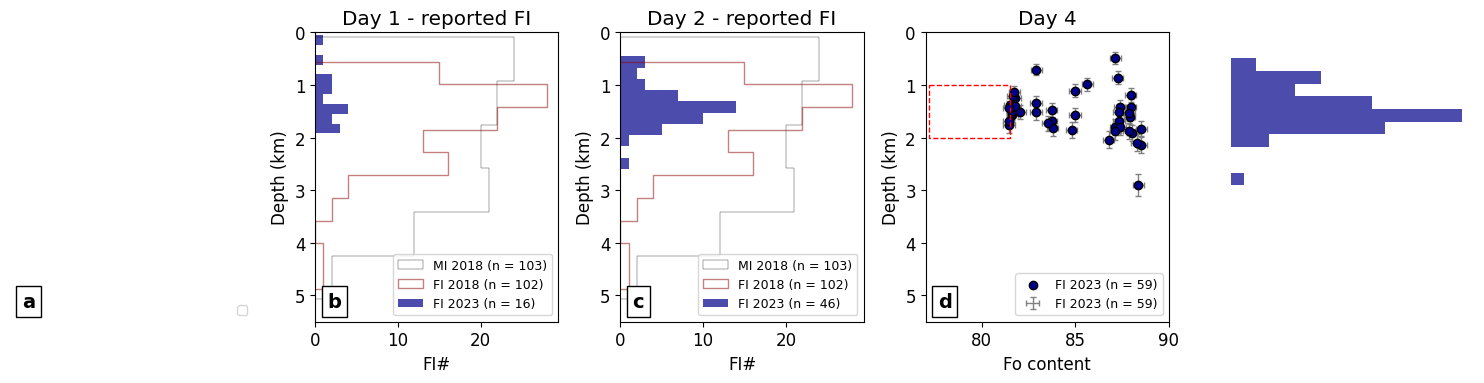

In [42]:
### Here we plot everything together
xmi18='Depth_RL(km)' #'Depth_RL(km)
xfi18='Mean_MC_D_km'#'Mean_MC_D_km'
xfi23_d1d2='Depth_km_ryanlerner'

# Filter for EOS (SO2 less than 5%)

fi23_filt=~(round(fi23['SO2_mol%'])>5)

# Filter for day2 data
day2_og['SO2_Diad_Ratio']=day2_og['SO2_Diad_Ratio'].fillna(0)
day2=day2_og.copy()

degass_filt=day2['SO2_Diad_Ratio']<0.1

day2_out=day2[~(degass_filt)]
day2_in=day2[degass_filt]

figure_mosaic="""
ABCDE
"""

fig,axes=plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 4))
val_lim=[5.5, 0]
val_lim_abc=[0,5.5]


fontsize=9
bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')

orient='horizontal'

# plot MI and FI from 2018 on B,C,D

for ax in ['B','C']:
    axes[ax].hist(mi18[xmi18],bins=10,color='white',edgecolor='k',histtype='step',
                linewidth=0.25,label='MI 2018 (n = '+str(mi18.shape[0])+')', orientation=orient)

    axes[ax].hist(fi18[xfi18],bins=10,color='lightgrey',edgecolor='darkred', histtype='step',
                alpha=0.5, label='FI 2018 (n = '+str(fi18.shape[0])+')', orientation=orient)
    for ax in ['B','C','E']:
        if orient=='horizontal':
            axes[ax].set_ylim(val_lim)
            axes[ax].set_ylabel("Depth (km)")
            axes[ax].set_xlabel("FI#")
        else:
            axes[ax].set_xlim(val_lim_abc)
            axes[ax].set_xlabel("Depth (km)")
            axes[ax].set_ylabel("FI#")

# Plot day1 FI 2023

axes['B'].hist(day1[xfi23_d1d2],bins=10,color='darkblue',alpha=0.7, label='FI 2023 (n = '+str(day1.shape[0])+')', orientation=orient)

axes['C'].hist(day2_in[xfi23_d1d2],bins=10,color='darkblue',alpha=0.7, label='FI 2023 (n = '+str(day2_in.shape[0])+')', orientation=orient)
# axes['C'].hist(day2_out[xfi23_d1d2],bins=10,color='pink',alpha=0.7, label='FI 2023 filtered (n = '+str(day2_out.shape[0])+')', orientation=orient)

###Day 4

Fo_var_fi23='Fo'

fi_data_col='Mean_MC_D_km'
fi_err_col='std_dev_MC_D_km'

## This actually plots data

axes['D'].errorbar(fi23[fi23_filt][Fo_var_fi23]*100, fi23[fi23_filt][fi_data_col], xerr=0.003*100,
                    yerr=fi23[fi23_filt][fi_err_col], 
                    color='grey', 
                    alpha=1,markeredgecolor=None,marker='', ls='none', 
                    barsabove=False, elinewidth=1, capsize=2,zorder=-2,
                    label='FI 2023 (n = '+str(fi23[fi23_filt].shape[0])+')')

axes['D'].scatter(fi23[fi23_filt][Fo_var_fi23]*100, fi23[fi23_filt][fi_data_col],
            marker='o', edgecolor='k',color='darkblue',label='FI 2023 (n = '+str(fi23[fi23_filt].shape[0])+')')

axes['E'].hist(fi23[fi23_filt][fi_data_col],alpha=0.7,density=1,orientation=orient,color='darkblue', bins=10)
axes['D'].set_ylim(val_lim)
axes['D'].set_ylabel("Depth (km)")
axes['D'].set_xlabel("Fo content")
axes['D'].set_xlim([77,90])

axes['E'].set_axis_off()
#### PLOT SETTINGS ######################################################
subplot_labels = ['A','B','C','D',]
pos_a2h=(0.05,0.05)
label_positions = [pos_a2h,pos_a2h,pos_a2h,pos_a2h]

for ax_key, pos in zip(subplot_labels, label_positions):
    ax = axes[ax_key]
    ax.text(pos[0], pos[1], ax_key.lower(), transform=ax.transAxes, fontsize=14, fontweight='bold', bbox=bbox)

### SAVE FIG##############################################################
axes['B'].set_title("Day 1 - reported FI")
axes['C'].set_title("Day 2 - reported FI")
axes['D'].set_title("Day 4")

# Calculated equilibrium Fo range from EPMA glass data and 17% Fe3+ (Lerner et al., 2021)
x_min = 77.17
x_max = 81.5

# Define the y-range for the box
y_min = 1
y_max = 2

# Create a box using a Rectangle patch
box = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='red', linestyle='dashed')
# axes['D'].plot([87,87],[5,0])
# Add the box to the subplot
axes['D'].add_patch(box)

for ax in ['A','B','C','D']:
    axes[ax].legend(loc='lower right',fontsize=fontsize)
axes['A'].set_axis_off()
plt.tight_layout()


fig.savefig(r"C:\Users\charl\Desktop\RapidResponse\Submission files\Fig2.pdf")

In [18]:
from scipy import stats

data1=fi18['Mean_MC_D_km'].sort_values()
data2=mi18['Depth_RL(km)'].sort_values()
data3=fi23[fi23_filt]['Mean_MC_D_km'].sort_values()

fi18vsfi23_KS=stats.ks_2samp(data1, data3)

mi18vsfi23_KS=stats.ks_2samp(data2, data3)

display(mi18vsfi23_KS)
display(fi18vsfi23_KS)

def calc_critKS_D(x1,x2,calpha=1.36):
    criticalksD=calpha*np.sqrt((len(x1)+len(x2))/(len(x1)*len(x2)))
    return criticalksD

#calc_critKS_D(data1, data3)
calc_critKS_D(data2, data3)

KstestResult(statistic=0.41039986835609676, pvalue=3.50799513312206e-06, statistic_location=1.881465356930927, statistic_sign=-1)

KstestResult(statistic=0.24858757062146894, pvalue=0.01552509101878269, statistic_location=1.881465356930927, statistic_sign=-1)

0.2220505214940306

In [ ]:
def calc_critKS_D(x1,x2,calpha=1.36):
    criticalksD=calpha*np.sqrt((len(x1)+len(x2))/(len(x1)*len(x2)))
    return criticalksD

def calculate_bootstrap_ks(data1, data2, data1_err, data2_err, iterations=2000,plot=True,plot_method='plot',xlabel="Pressure (kbar)"):
    # plot_method can be 'plot' to get a simple CDF, smoothed. If anything else, it will use step function to plot.
    # if plot is true, a figure is produced, if anything else it will not plot. 

    def calculate_ks_stat(data1, data2):
        return stats.ks_2samp(data1, data2)

    bootstrap_ks_stats = []
    bootstrap_p_values = []
    resampled_distributions = []

    for _ in range(iterations):
        data1_resample = np.random.normal(data1, data1_err)
        data2_resample = np.random.normal(data2, data2_err)
        
        ks_result = calculate_ks_stat(data1_resample, data2_resample)
        bootstrap_ks_stats.append(ks_result.statistic)
        bootstrap_p_values.append(ks_result.pvalue)
        
        resampled_distributions.append({
            'data1_resample': np.sort(data1_resample),
            'data2_resample': np.sort(data2_resample),
        })

    bootstrap_ks_stats = np.array(bootstrap_ks_stats)
    bootstrap_p_values = np.array(bootstrap_p_values)

    data1_resample_sorted = np.sort(data1_resample)
    data2_resample_sorted = np.sort(data2_resample)

    original_ks_stat, original_p_value = calculate_ks_stat(data1, data2)
    critD=calc_critKS_D(data1_resample_sorted,data2_resample_sorted)

    results = {
        'original_ks_stat': original_ks_stat,
        'original_p_value': original_p_value,
        'critical D-val':critD,
        'bootstrap_ks_stats': bootstrap_ks_stats,
        'bootstrap_p_values': bootstrap_p_values,
        'bootstrap_ks_mean': np.mean(bootstrap_ks_stats),
        'bootstrap_ks_std': np.std(bootstrap_ks_stats),
        'bootstrap_p_mean': np.mean(bootstrap_p_values),
        'bootstrap_p_std': np.std(bootstrap_p_values),
        'data1_resample_sorted': data1,
        'data2_resample_sorted': data2,
        'resampled_distributions': resampled_distributions,
    }

    if plot!=False:
        fig,ax=plt.subplots(1,1, figsize=(7, 5))
        # This plots all the bootstraped CDF 
        for i, distribution in enumerate(results['resampled_distributions']):
            if plot_method!='plot':
                ax.step(np.concatenate([distribution['data1_resample'],distribution['data1_resample'][-1:]]),np.arange(distribution['data1_resample'].size + 1) / distribution['data1_resample'].size, color='royalblue',alpha=0.2)
                ax.step(np.concatenate([distribution['data2_resample'],distribution['data2_resample'][-1:]]),np.arange(distribution['data2_resample'].size + 1) / distribution['data2_resample'].size, color='wheat',alpha=0.2)
            else:
                ax.plot(np.sort(distribution['data1_resample']), np.arange(1, len(distribution['data1_resample']) + 1) / len(distribution['data1_resample']), color='royalblue', alpha=0.2)
                ax.plot(np.sort(distribution['data2_resample']), np.arange(1, len(distribution['data2_resample']) + 1) / len(distribution['data2_resample']), color='wheat', alpha=0.2)
        

        # This plots the original data CDF
        if plot_method!='plot':
            ax.step(np.concatenate([results['data1_resample_sorted'],results['data1_resample_sorted'][-1:]]),np.arange(results['data1_resample_sorted'].size + 1) / results['data1_resample_sorted'].size, color='midnightblue', linewidth=2,label='Data1')
            ax.step(np.concatenate([results['data2_resample_sorted'],results['data2_resample_sorted'][-1:]]),np.arange(results['data2_resample_sorted'].size + 1) / results['data2_resample_sorted'].size, color='darkorange', linewidth=2,label='Data2')
        else:
            ax.plot(results['data1_resample_sorted'], np.arange(1, len(results['data1_resample_sorted']) + 1) / len(results['data1_resample_sorted']), color='midnightblue',linewidth=2, label='Data1')
            ax.plot(results['data2_resample_sorted'], np.arange(1, len(results['data2_resample_sorted']) + 1) / len(results['data2_resample_sorted']), color='darkorange',linewidth=2, label='Data2')

        # This creates a text box with all the statistics
        mean_ks_text = f"MC KS Mean: {results['bootstrap_ks_mean']:.3f} ± {results['bootstrap_ks_std']:.3f}"
        mean_p_text = f"MC P-val Mean: {results['bootstrap_p_mean']:.3f} ± {results['bootstrap_p_std']:.3f}"
        text_box = f"Sample KS Statistic: {results['original_ks_stat']:.3f}\nSample P-val: {results['original_p_value']:.3f}\nCritical KS D: {critD:.3f}\n{mean_ks_text}\n{mean_p_text}"

        ax.text(0.55, 0.5, text_box, transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        ax.set_xlim([0,max(data1.max(), data2.max())])
        ax.legend()
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Cumulative probability")
    
    if 'fig' in locals():
        final_result=fig,results
    else:
        final_result=results
    
    return final_result



# ###### SET YOUR DATA ENTRIES AND ITERATIONS##### Example here
# fill4_data = sorted_lei_data['FI_LL4']['Mean_MC_P_kbar'] #data 1 -pd.Series, sorted
# fill4_errors = sorted_lei_data['FI_LL4']['std_dev_MC_P_kbar'] #data 1 error

# msatll4_data = sorted_lei_data['MSAT_LL4']['Magmasat Saturation Pressure (bar) (Total, PEC-corr CO2, Measured H2O)']#data 2
# msatll4_errors = sorted_lei_data['MSAT_LL4']['Magmasat_err4cdf'] #data 2 error

# iterations=1000

# # Calculate the results don't call fig if you didn't say plot=True
# final_result= calculate_bootstrap_ks(fill4_data, msatll4_data, fill4_errors, msatll4_errors, iterations=iterations,plot=True,plot_method='step',xlabel="Pressure (kbar)")
